## Imports

In [1]:

import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix

import torch
from torchvision import datasets, transforms

#quanutm lib
import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e3_enhance
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Data

In [3]:
df=pd.read_csv("cancer.csv", nrows=500)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
diagnosis=[]
for d in df.diagnosis:
    if d=="M":
        diagnosis.append(0.0)
    else:
        diagnosis.append(1.0)
df["diagnosis"]=diagnosis

In [5]:
print('Malign: ', df['diagnosis'].value_counts()[0])
print('Benign: ', df['diagnosis'].value_counts()[1])

Malign:  195
Benign:  305


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       500 non-null    int64  
 1   diagnosis                500 non-null    float64
 2   radius_mean              500 non-null    float64
 3   texture_mean             500 non-null    float64
 4   perimeter_mean           500 non-null    float64
 5   area_mean                500 non-null    float64
 6   smoothness_mean          500 non-null    float64
 7   compactness_mean         500 non-null    float64
 8   concavity_mean           500 non-null    float64
 9   concave points_mean      500 non-null    float64
 10  symmetry_mean            500 non-null    float64
 11  fractal_dimension_mean   500 non-null    float64
 12  radius_se                500 non-null    float64
 13  texture_se               500 non-null    float64
 14  perimeter_se             5

In [7]:
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0
mean,3.263049e+07,0.610000,14.224206,19.086320,92.606620,662.844800,0.095978,0.103948,0.089941,0.049446,...,25.508500,108.258320,896.003200,0.131972,0.256324,0.276420,0.115980,0.292212,0.083778,NaN
std,1.326933e+08,0.488238,3.476809,4.164842,23.983476,349.357241,0.013666,0.053096,0.080259,0.038875,...,6.063133,33.312706,571.074422,0.022739,0.159147,0.209012,0.065896,0.063366,0.018108,NaN
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.667040e+05,0.000000,11.807500,16.070000,75.995000,430.550000,0.085992,0.063622,0.028885,0.020245,...,21.017500,84.567500,522.600000,0.116200,0.145925,0.114475,0.063302,0.251700,0.071270,NaN
50%,9.014320e+05,1.000000,13.435000,18.680000,86.735000,556.150000,0.095825,0.091280,0.064315,0.033870,...,25.240000,97.980000,691.750000,0.131250,0.214850,0.231400,0.100650,0.283100,0.079900,NaN
75%,8.910808e+06,1.000000,16.115000,21.562500,106.225000,800.775000,0.105100,0.130500,0.132150,0.074928,...,29.350000,127.150000,1150.750000,0.146000,0.343525,0.389450,0.166850,0.320050,0.092065,NaN
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [8]:
#Data seams pretty clean  without any nan value 

In [9]:
## engineering two new features to have 32 feutures that can be encoded om 5 qubits.
over_average = []
under_average = []

mean = {}
std = {}
for col in df:
     if col not in ["id","diagnosis" ]:
        mean[col]=df[col].mean()
        std[col]=df[col].std()

for index,row in df.iterrows():
    o_average=0
    u_average=0
    for col in df:
        if col not in ["id","diagnosis" ]:
            if  row[col]> mean[col]+2* std[col]:
                o_average = o_average + 1
            if  row[col]< mean[col]+2* std[col]:
                u_average= u_average + 1
                
    over_average.append(o_average)
    under_average.append(u_average)

df["over_average"] = over_average
df["under_average"] = under_average

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
0,842302,0.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN,13,17
1,842517,0.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN,0,30
2,84300903,0.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN,1,29
3,84348301,0.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN,12,18
4,84358402,0.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN,0,30


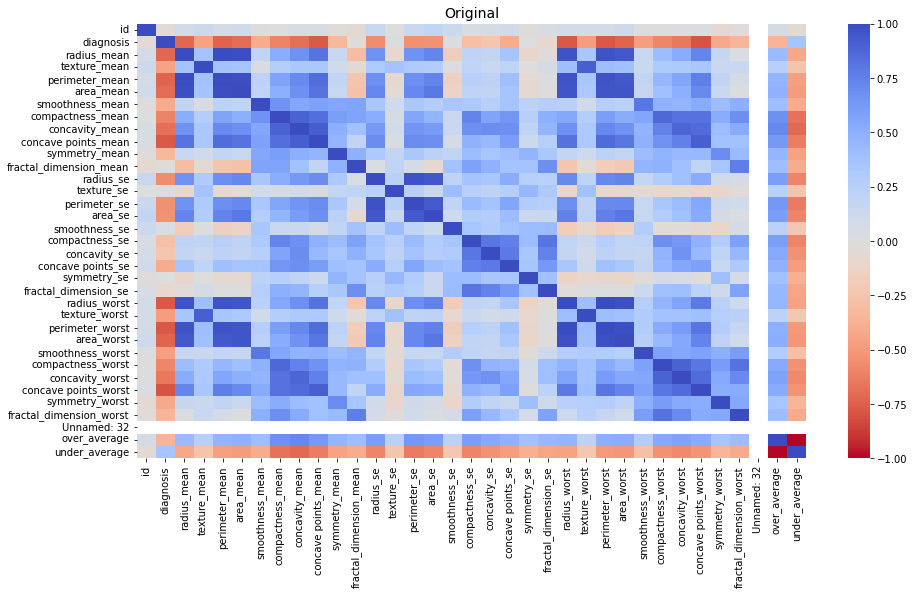

In [10]:
plot_correlation_matrix(df, "Original")

In [11]:
df = df.sample(frac=1)
fraud_df = df.loc[df['diagnosis'] == 0]
non_fraud_df = df.loc[df['diagnosis'] == 1][:195]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
41,855563,0.0,10.95,21.35,71.90,371.1,0.12270,0.12180,0.10440,0.05669,...,514.0,0.1909,0.2698,0.40230,0.14240,0.2964,0.09606,NaN,1,29
300,892438,0.0,19.53,18.90,129.50,1217.0,0.11500,0.16420,0.21970,0.10620,...,2053.0,0.1495,0.4116,0.61210,0.19800,0.2968,0.09929,NaN,3,27
65,859283,0.0,14.78,23.94,97.40,668.3,0.11720,0.14790,0.12670,0.09029,...,925.1,0.1648,0.3416,0.30240,0.16140,0.3321,0.08911,NaN,0,30
310,893783,1.0,11.70,19.11,74.33,418.7,0.08814,0.05253,0.01583,0.01148,...,483.1,0.1223,0.1087,0.07915,0.05741,0.3487,0.06958,NaN,0,30
303,892657,1.0,10.49,18.61,66.86,334.3,0.10680,0.06678,0.02297,0.01780,...,375.4,0.1413,0.1044,0.08423,0.06528,0.2213,0.07842,NaN,0,30


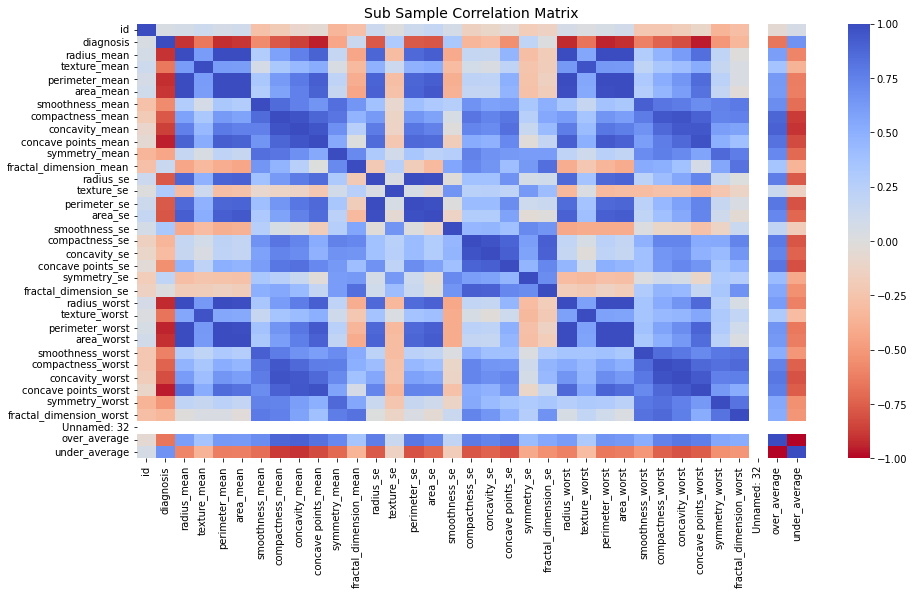

In [12]:
sub_sample_corr = sub_sample_df.corr()
plot_correlation_matrix(sub_sample_corr, "Sub Sample Correlation Matrix")

In [13]:
for col in df:
    if col not in ["id","diagnosis" ]:
        df[col]=df[col]/df[col].max()
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0,500.000000,500.000000
mean,3.263049e+07,0.610000,0.506019,0.485904,0.491282,0.265032,0.663292,0.300949,0.210733,0.245754,...,0.210626,0.592867,0.242273,0.220783,0.398557,0.440211,0.403749,NaN,0.062500,0.958333
std,1.326933e+08,0.488238,0.123686,0.106030,0.127233,0.139687,0.094446,0.153722,0.188047,0.193216,...,0.134244,0.102153,0.150423,0.166943,0.226448,0.095459,0.087266,NaN,0.140564,0.093709
min,8.670000e+03,0.000000,0.248346,0.247200,0.232308,0.057377,0.431997,0.056109,0.000000,0.000000,...,0.043535,0.319721,0.025794,0.000000,0.000000,0.235764,0.265253,NaN,0.000000,0.333333
25%,8.667040e+05,0.000000,0.420046,0.409114,0.403156,0.172151,0.594281,0.184199,0.067678,0.100621,...,0.122849,0.522013,0.137925,0.091434,0.217534,0.379180,0.343470,NaN,0.000000,0.966667
50%,9.014320e+05,1.000000,0.477944,0.475560,0.460133,0.222371,0.662232,0.264273,0.150691,0.168340,...,0.162612,0.589623,0.203072,0.184824,0.345876,0.426484,0.385060,NaN,0.000000,1.000000
75%,8.910808e+06,1.000000,0.573284,0.548943,0.563528,0.320182,0.726330,0.377823,0.309630,0.372403,...,0.270510,0.655885,0.324693,0.311062,0.573368,0.482148,0.443687,NaN,0.050000,1.000000
max,9.113205e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000


In [14]:
def find_strongest_correlations(dataframe, qubits):
        
    class_correlations = dataframe.loc['diagnosis', :]
    class_correlations = class_correlations.drop(index = 'diagnosis')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(qubits/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    
    
print(find_strongest_correlations(sub_sample_corr, 8))

(['under_average', 'concave points_worst', 'texture_se', 'perimeter_worst', 'smoothness_se', 'radius_worst', 'symmetry_se', 'concave points_mean'], [0.3235022597496148, -0.7910561435463428, 0.018956411309735313, -0.7651335361178419, 0.007836843659742231, -0.7591309269627567, -0.0006777268346286565, -0.7591128704032053])


In [15]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 8)

In [16]:
malign=df[df["diagnosis"]==0][feature_list]
malign.head()

,under_average,concave points_worst,texture_se,perimeter_worst,smoothness_se,radius_worst,symmetry_se,concave points_mean
57,1.0,0.630241,0.235415,0.460589,0.117539,0.495838,0.230146,0.403728
126,1.0,0.456701,0.205732,0.450637,0.131320,0.468646,0.167574,0.153330
218,1.0,0.625430,0.242784,0.677946,0.218567,0.713929,0.240279,0.431958
385,1.0,0.467010,0.333060,0.406847,0.267009,0.438124,0.220393,0.261978
255,1.0,0.472165,0.165773,0.430334,0.204015,0.454772,0.261178,0.260736


In [17]:
benign=df[df["diagnosis"]!=0][feature_list]
benign.head()

,under_average,concave points_worst,texture_se,perimeter_worst,smoothness_se,radius_worst,symmetry_se,concave points_mean
475,1.0,0.336186,0.099795,0.371099,0.156537,0.390954,0.202787,0.152982
425,1.0,0.088625,0.274514,0.278344,0.183874,0.308269,0.183027,0.025641
305,1.0,0.165464,0.365609,0.324005,0.196659,0.345172,0.404560,0.065258
386,1.0,0.314089,0.170092,0.348925,0.141503,0.364317,0.243319,0.125944
360,1.0,0.056186,0.195026,0.345621,0.185769,0.380688,0.258771,0.027083


In [18]:
input_data=malign.to_numpy()
input_data

array([[1.        , 0.63024055, 0.23541453, ..., 0.49583796, 0.23014566,
        0.40372763],
       [1.        , 0.45670103, 0.20573183, ..., 0.46864595, 0.16757441,
        0.15333002],
       [1.        , 0.62542955, 0.24278403, ..., 0.71392897, 0.24027866,
        0.43195825],
       ...,
       [1.        , 0.50652921, 0.28474923, ..., 0.5563263 , 0.26485117,
        0.32683897],
       [1.        , 0.39862543, 0.23480041, ..., 0.49889012, 0.19252692,
        0.17087475],
       [1.        , 0.63917526, 0.15023541, ..., 0.69339623, 0.17593414,
        0.34875746]])

## Training node

In [19]:
shots = 2500
nr_trash=2
nr_latent=1
nr_ent=0

spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

nr_layers = 4

Qubits: [0, 1, 2, 3, 4, 5]


In [20]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state, x):
    # Initialization
    setAB_amplitude(spec, init_params)
    setAux(spec, reinit_state)

    #encoder 
    for params in encoder_params:
        e3_enhance(params, float(x), spec)

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

## Training parameters 

In [21]:
epochs = 500
learning_rate = 0.0003
batch_size = 5
num_samples = 0.8 # proportion of the data used for training 

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [22]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [23]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [24]:
def fidelity(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output =  training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
       
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [25]:
def iterate_batches(X, batch_size):
    
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [26]:
training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]
test_data = [torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples),len(input_data))]

C:\Users\tomut\AppData\Local\Temp/ipykernel_17488/3998820717.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]


In [27]:
batches=iterate_batches(training_data, batch_size)

In [28]:
X_training = training_data
X_tes = test_data

In [29]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder = nr_layers * 2 * nr_encod_qubits + 2 * len(spec.trash_qubits)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)

###  training

In [30]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

In [31]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

benign_fid=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
        b_fidel = fidelity(encoder_params, benign_data )
        benign_fid.append(b_fidel)
        print("benign fid:{}".format(b_fidel))
        
       
        experiment_parameters={"autoencoder":"e2","params":encoder_params}
        f=open("Cancer_encoder_e3-SelectedFeautures/params"+str(epoch)+".txt","w")
        f.write(str(experiment_parameters))
        f.close()
        

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.692411058238312 | Fidelity:0.5915389148733982
Test-Epoch:0 | Loss:1.7023485434496028 | Fidelity:0.5878683148046853
benign fid:0.6108305477288052
Epoch:5 | Loss:1.604593157002295 | Fidelity:0.6238810780972908
Test-Epoch:5 | Loss:1.6129877166379971 | Fidelity:0.6204133306671098
benign fid:0.6361266783319312
Epoch:10 | Loss:1.5191694947310874 | Fidelity:0.6589639556558131
Test-Epoch:10 | Loss:1.5260679535953936 | Fidelity:0.655733471856139
benign fid:0.6615821038738603
Epoch:15 | Loss:1.445882187083249 | Fidelity:0.6924417511601713
Test-Epoch:15 | Loss:1.4515009338900136 | Fidelity:0.6894489512746292
benign fid:0.6851108462773114
Epoch:20 | Loss:1.3877043827491233 | Fidelity:0.7215962442162626
Test-Epoch:20 | Loss:1.3923751047493906 | Fidelity:0.718791548529782
benign fid:0.7054571300712936
Epoch:25 | Loss:1.3428254707643243 | Fidelity:0.7458363351892014
Test-Epoch:25 | Loss:1.3468383631508432 | Fidelity:0.7431677281014598
benign fid:0.7226196487815569
Epoch:30 | Loss:1.3

benign fid:0.9644224562792644
Epoch:250 | Loss:1.0231950705199024 | Fidelity:0.9774705447900731
Test-Epoch:250 | Loss:1.0219772834805827 | Fidelity:0.9786107200797313
benign fid:0.9644762696756066
Epoch:255 | Loss:1.0231219318498368 | Fidelity:0.9775376796360123
Test-Epoch:255 | Loss:1.0219354582723543 | Fidelity:0.9786494463914488
benign fid:0.9648771079678251
Epoch:260 | Loss:1.0230530509880909 | Fidelity:0.9776020000458877
Test-Epoch:260 | Loss:1.0219006648030866 | Fidelity:0.9786817399886368
benign fid:0.9651210441967867
Epoch:265 | Loss:1.0229996605910745 | Fidelity:0.9776501121385746
Test-Epoch:265 | Loss:1.0218671232151586 | Fidelity:0.978712093436152
benign fid:0.9654942688359258
Epoch:270 | Loss:1.0229447688437006 | Fidelity:0.9777020972092629
Test-Epoch:270 | Loss:1.0218608569472705 | Fidelity:0.9787188879758053
benign fid:0.9655957468759939
Epoch:275 | Loss:1.0228905231532046 | Fidelity:0.977751529454789
Test-Epoch:275 | Loss:1.02185160517284 | Fidelity:0.9787274749630137
be

Test-Epoch:495 | Loss:1.021312005974206 | Fidelity:0.979241901336596
benign fid:0.9686254691817673


## Rezults

In [32]:
import matplotlib.pyplot as plt

fidelity: 0.9787211977202637


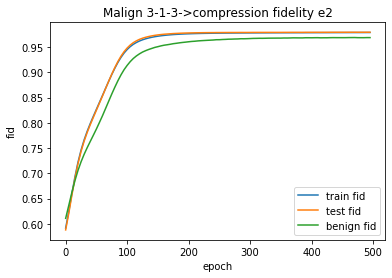

In [33]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(benign_fid),label="benign fid")

plt.legend()
plt.title("Malign 3-1-3->compression fidelity e2",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.0218616614502056


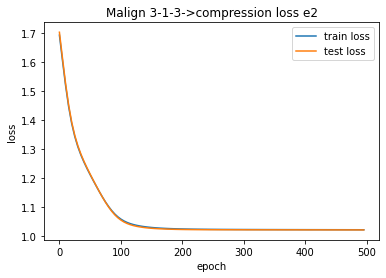

In [34]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("Malign 3-1-3->compression loss e2",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

In [35]:
name = "Cancer_encoder_e2"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent ,"nr_ent":nr_ent  }
Training_param = { "num_samples" : num_samples,
                    "batch_size" :batch_size,
                    "epochs" :epochs,
                    "learning_rate" : learning_rate ,
                    "beta1" : beta1,
                    "beta2 ":beta2,
                     "optimizer":"Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}

# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )

16769

## Benign performance 

In [36]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

loss = cost(encoder_params, benign_data )
fidel = fidelity(encoder_params, benign_data )

print("Benign results:")
print("fidelity=",fidel)
print("loss=",loss)


C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Benign results:
fidelity= 0.9686634281270281
loss= 1.032635495697161


## Classifyer

In [37]:
beningn_flist=[]
for b in benign_data:
    f=fidelity(encoder_params, [b])
    beningn_flist.append(f.item())
    
print(min(beningn_flist))
print(max(beningn_flist))

0.8078985907456403
0.9912305213833068


In [38]:
malign_flist=[]
for b in training_data:
    f=fidelity(encoder_params, [b])
    malign_flist.append(f.item())
    
print(min(malign_flist))
print(max(malign_flist))

0.9287316859592463
0.9930035823246325


In [39]:
beningn_flist

[0.9749447488975224,
 0.9655777217818617,
 0.9588183949913125,
 0.9803951384608939,
 0.9555637392792501,
 0.9742550728468237,
 0.9631860937864786,
 0.9566169942790423,
 0.9697808331126119,
 0.9770589515316658,
 0.9807390173639657,
 0.9720532825270747,
 0.9726605708061379,
 0.9782922684273672,
 0.9788455063223795,
 0.9737027487837098,
 0.9746909384245674,
 0.9572374778289684,
 0.8901910659139778,
 0.9795831592834321,
 0.9712580739389333,
 0.9597255122293135,
 0.9755323389369567,
 0.957264200732894,
 0.8078985907456403,
 0.9812892601388594,
 0.9736388350371801,
 0.9781082047615645,
 0.9783891952272469,
 0.9782959562188466,
 0.9796656616539408,
 0.9867271291896256,
 0.9652330733819714,
 0.974917048927768,
 0.9536166217111192,
 0.9788256343088078,
 0.9674332679946798,
 0.9604952672119256,
 0.9622175579492139,
 0.9544624593460516,
 0.9517372001644201,
 0.9699377988381809,
 0.9816474753765894,
 0.9711430580607986,
 0.9840551852154916,
 0.9852034992417635,
 0.9777028233238287,
 0.972992798082

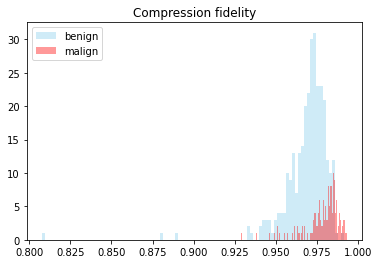

In [40]:
plt.hist(beningn_flist, bins = 100 ,label="benign", color = "skyblue",alpha=0.4)
plt.hist(malign_flist, bins =100 ,label="malign",color = "red",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.show()

In [41]:
split=0.99


print("split:",split)
b_e=[]
for i in beningn_flist:
    if i<split:
        b_e.append(1)
    else:
        b_e.append(0)
ab_ac=sum(b_e)/len(b_e)
print("benign classification accuracy:",ab_ac)
m_e=[]
for i in malign_flist:
    if i>split:
        m_e.append(1)
    else:
        m_e.append(0)
am_ac=sum(m_e)/len(m_e)
print("malign classification accuracy:",am_ac)
t_ac=(sum(b_e)+sum(m_e))/(len(b_e)+len(m_e))
print("total accuracy:",t_ac)

split: 0.99
benign classification accuracy: 0.9967213114754099
malign classification accuracy: 0.0641025641025641
total accuracy: 0.6811279826464208
